
[Open In Colab](https://colab.research.google.com/github/google/fedjax/blob/main/experimental/notebooks/emnist_compression.ipynb)

In [1]:
# Uncomment these to install fedjax.
# !pip install fedjax
# !pip install --upgrade git+https://github.com/google/fedjax.git

In [2]:
import fedjax
import jax
from jax import jit
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import optax
import time
from typing import Any, NamedTuple

fedjax.training.set_tf_cpu_only()

```
# To disable jit, use 'with jax.disable_jit():'
# For example,
@jax.jit
def f(x):
  print(x)
  return jnp.sum(x)

x = jnp.ones([])

print('jit enabled')
for _ in range(10):
  f(x)

print('jit disabled')
with jax.disable_jit():
  for _ in range(10):
    f(x)
```

Reusing cached file '/tmp/emnist_data/federated_emnist_train.sqlite'
Reusing cached file '/tmp/emnist_data/federated_emnist_test.sqlite'


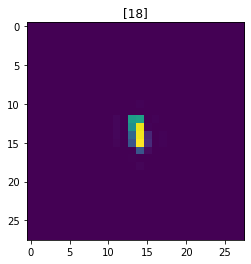

In [3]:
# Load the model and the data.
model = fedjax.models.emnist.create_conv_model(only_digits=False)
train, test = fedjax.datasets.emnist.load_data(only_digits=False,
                                               cache_dir='/tmp/emnist_data')
# Print a single client data to verify data is loaded.
example_client_id = list(train.client_ids())[0]
single_client_data = list(train.get_client(
    example_client_id).batch(batch_size=1))
pixels = single_client_data[0]['x']
label = single_client_data[0]['y']
plt.title(f'{label}')
plt.imshow(pixels.reshape(28, 28))

In [4]:
@fedjax.dataclass
class ServerState:
  params : fedjax.Params
  opt_state : fedjax.optimizers.OptState
  aggregator_state: Any

# Define federated algorithm.
def fed_avg(grad_fn,
            client_optimizer,
            server_optimizer,
            client_batch_hparams,
            aggregator):
  """Builds the basic implementation of federated averaging."""

  def init(params):
    """ Initialize the federated algorithm"""
    opt_state = server_optimizer.init(params)
    aggregator_state = aggregator.init()
    return ServerState(params, opt_state, aggregator_state)

  def apply(server_state, clients): 
    """ Apply one round of federated algorithm/"""
    client_delta_params_weights = []
    for client_id, client_dataset, client_rng in clients:
      delta_params, client_loss = client_update(
          server_state.params, client_dataset, client_rng)
      client_delta_params_weights.append((client_id, 
                                          delta_params,
                                          len(client_dataset)))
    weighted_averaged_delta, new_aggregator_state = aggregator.apply(
        client_delta_params_weights,
        server_state.aggregator_state)
    server_state = server_update(server_state,
                                 weighted_averaged_delta,
                                 new_aggregator_state)
    return server_state

  def client_update(server_params, client_dataset, client_rng):
    params = server_params
    opt_state = client_optimizer.init(params)
    padded_batches = fedjax.padded_batch_client_datasets(
        [client_dataset], batch_size=1024)
    metrics = fedjax.evaluate_model(model, params, padded_batches)
    client_loss = metrics['loss']
    for batch in client_dataset.shuffle_repeat_batch(client_batch_hparams):
      client_rng, use_rng = jax.random.split(client_rng)
      grads = grad_fn(params, batch, use_rng)
      opt_state, params = client_optimizer.apply(grads, opt_state, params)
    delta_params = jax.tree_util.tree_multimap(lambda a, b: a - b,
                                               server_params, params)
    return delta_params, client_loss

  def server_update(server_state, mean_delta_params, new_aggregator_state):
    opt_state, params = server_optimizer.apply(mean_delta_params,
                                               server_state.opt_state,
                                               server_state.params)
    return ServerState(params, opt_state, new_aggregator_state)

  return fedjax.FederatedAlgorithm(init, apply)

In [5]:
# Run federated algorithm.
# The hyper-parameters here is not the state of the art. It achieves a
# global test accuracy as follows
# num_levels, server_learning_rate_starting_point, test_accuracy 
# 256, 1.0, 85.6%
# 2, 0.01, 59.2%

num_rounds = 1500
num_clients_per_round = 10
client_batch_size = 10
client_optimizer = fedjax.optimizers.sgd(learning_rate=0.16)
server_schedule = optax.exponential_decay(1.0, 500, 0.5)
server_optimizer = fedjax.optimizers.sgd(server_schedule)
client_batch_hparams = fedjax.ShuffleRepeatBatchHParams(
    batch_size=10,num_epochs=1)
grad_fn = fedjax.model_grad(model)
# Creating a federated algorithm with 8 bits of quantization.
algorithm = fed_avg(grad_fn, 
                    client_optimizer,
                    server_optimizer,
                    client_batch_hparams,
                    fedjax.aggregators.uniform_stochastic_quantizer(
                        256, jax.random.PRNGKey(0)))
init_params = model.init(jax.random.PRNGKey(0))
rng = jax.random.PRNGKey(42)
server_state = algorithm.init(init_params)
sampler = fedjax.client_samplers.UniformGetClientSampler(
    train, num_clients_per_round, seed=0)
start = time.time()
for round_num in range(1, num_rounds + 1):
  clients = sampler.sample()
  server_state = algorithm.apply(server_state, clients)
  if round_num % 100 == 0:
    print('round_num: {}, mean_round_duration: {} sec'.format(
        round_num, (time.time() - start)/100))
    start = time.time() 
final_params = server_state.params

overall_metrics = fedjax.evaluate_model(
    model,
    final_params,
    fedjax.padded_batch_federated_data(test, batch_size=1024))
print(overall_metrics)

round_num: 100, mean_round_duration: 0.4552804470062256 sec
round_num: 200, mean_round_duration: 0.3484324908256531 sec
round_num: 300, mean_round_duration: 0.3398168110847473 sec
round_num: 400, mean_round_duration: 0.34802984476089477 sec
round_num: 500, mean_round_duration: 0.3342078638076782 sec
round_num: 600, mean_round_duration: 0.33866923570632934 sec
round_num: 700, mean_round_duration: 0.34813843011856077 sec
round_num: 800, mean_round_duration: 0.3442531204223633 sec
round_num: 900, mean_round_duration: 0.3395417761802673 sec
round_num: 1000, mean_round_duration: 0.338899233341217 sec
round_num: 1100, mean_round_duration: 0.33501195192337035 sec
round_num: 1200, mean_round_duration: 0.34103004932403563 sec
round_num: 1300, mean_round_duration: 0.338041832447052 sec
round_num: 1400, mean_round_duration: 0.3409284591674805 sec
round_num: 1500, mean_round_duration: 0.33965426445007324 sec
{'accuracy': DeviceArray(0.8554393, dtype=float32), 'loss': DeviceArray(0.42102018, dtype=